# Penalty method: solve 2d Poisson equation by PINN

---



### Domain:  $D=[0,1]^2$ 
### PDE
$$
\begin{aligned}
   \Delta u =& f\,\quad \mbox{in}\, D \\
   u|_{\partial D} =& g\quad \mbox{on}\, \partial D
   \end{aligned}
$$

### Aim: 
The boundary condition brings a constraint to the training task. The code below tests the penalty method in solving this PDE task. 

### In penalty method, the constraint is added into the objective function as a penalty term. In our case, this leads to the total loss:
  loss = pde_loss + $\alpha \times$ boundary_loss,

where $\alpha$ is the penalty constant, and

* pde_loss:     $\frac{1}{n} \sum_{i=1}^n |\Delta u(X_i)-f(X_i))|^2$

* boundary_loss :    $\frac{1}{m} \sum_{i=1}^m |u(Y_i)-g(Y_i))|^2$




### First, load neceesary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import math 
import torch.nn as nn
import random
import itertools 
from tqdm import tqdm
import os
import time

# load the class that defines PINN losses of the Poisson equation we want to solve 
from test_problems import PoissonEqnByPINN


### Set parameters

In [8]:
n = 10000
n_bndry = 1000

batch_size_X = 100
batch_size_Y = 100

# penalty constant
alpha = 5.0
# total number of learning steps
num_iters = 2000
# layers of the neural network.
layer_dims = [2, 20, 20, 20, 1] 
optimizer_name = 'Adam'
learning_rate = 0.01


problem = PoissonEqnByPINN(u_coeff=4.0)

# create neural network that represents the solution of the PDE
model = problem.create_model(layer_dims)
# prepare data
[X, Y] = [problem.get_X(), problem.get_Y()]

ref_u = problem.get_reference_solution()

# prepare optimizer
if optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
# --- start the training over the required number of epochs ---
train_losses = []

print ("\ntraining starts, %d iterations in total." % num_iters) 
rng = np.random.default_rng()
for iter in tqdm(range(num_iters)):
    # Train the model by going through the whole dataset
    batch_idx_X = rng.integers(X.shape[0], size=batch_size_X)
    batch_idx_Y = rng.integers(Y.shape[0], size=batch_size_Y)

    X_batch = torch.tensor(X[batch_idx_X, :], requires_grad=True).float()
    Y_batch = torch.tensor(Y[batch_idx_Y, :]).float()

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()

    loss1 = problem.F(model, X_batch)
    loss2 = problem.G(model, Y_batch)

    loss = loss1 + alpha * loss2
    # Get gradient with respect to parameters of the model
    loss.backward()
    # Store loss
    loss3 = ((model(X_batch) - ref_u(X_batch))**2).mean()

    train_losses.append([loss.detach().item(), loss1.detach().item(), loss2.detach().item(), loss3.detach().item()])
    # Updating parameters
    optimizer.step()
    
print ("training ends.\n") 



training starts, 2000 iterations in total.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 507.86it/s]

training ends.



### Plot the solution

Losses:


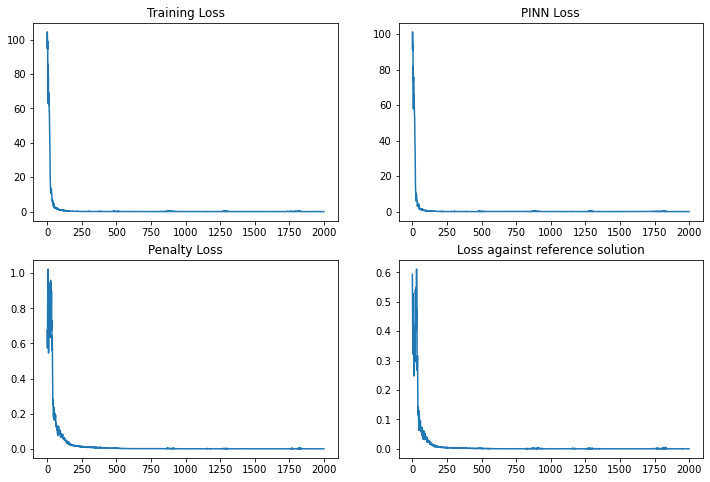

Solution u:


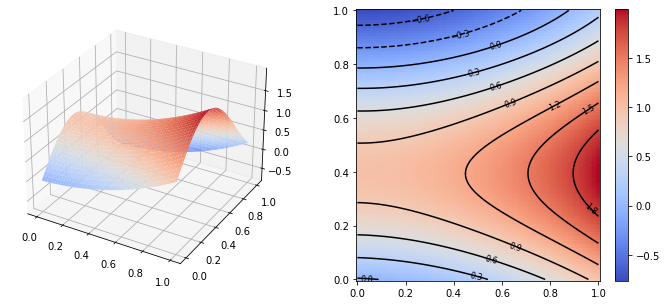

In [9]:
ngrid = 100
grid1d = np.linspace(0, 1.0, ngrid)
x_plot = np.outer(grid1d, np.ones(ngrid)) 
y_plot = np.outer(grid1d, np.ones(ngrid)).T 

x2d = torch.from_numpy(np.concatenate((x_plot.reshape(ngrid * ngrid, 1), y_plot.reshape(ngrid * ngrid, 1)), axis=1)).float()
u = model(x2d).detach().numpy()

u = u.reshape(ngrid, ngrid)

loss_list = np.array(train_losses)
print ('Losses:')
fig, ax = plt.subplots(2,2, figsize=(12,8))
ax[0,0].plot(loss_list[:,0])
ax[0,0].set_title('Training Loss')
ax[0,1].plot(loss_list[:,1])
ax[0,1].set_title('PINN Loss')
ax[1,0].plot(loss_list[:,2])
ax[1,0].set_title('Penalty Loss')
ax[1,1].plot(loss_list[:,3])
ax[1,1].set_title('Loss against reference solution')

plt.show()
fig_name = f'losses.jpg'
#fig.savefig(fig_name)
plt.close()

print ('Solution u:')

fig = plt.figure(figsize=(12,5))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.add_subplot(1, 2, 2)  
ax0.plot_surface(x_plot, y_plot, u, cmap='coolwarm', edgecolor='none')
im = ax1.pcolormesh(x_plot, y_plot, u, cmap='coolwarm',shading='auto')
contours = ax1.contour(x_plot, y_plot, u, 10, colors='black')
ax1.clabel(contours, inline=False, fontsize=8)
fig.colorbar(im, ax=ax1)
fig_name = f'u.jpg'
#fig.savefig(fig_name)
plt.show()
#plt.close()
